In [29]:
import numpy as np
import xarray as xr
from useful_functions import data_compiler
from useful_functions import month_genesis_locs
from useful_functions import grid_counter
from useful_functions import environmental_select_stack
from useful_functions import create_genesis_grid_labels
from useful_functions import take_closest_point
from distance import distance_calculator
from distance import pointdist_calc
import os
import tropycal.tracks as tracks
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cartopy.crs as ccrs

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Compile Environmental Data
vars_list = os.listdir("/glade/work/acheung/TC_Genesis") # Determine Variables
vars_list.remove('.DS_Store')
vars_list.remove('CRH_ERA5')
# all_stacked_vars = []
all_vars_list = []
for vars_list_now in vars_list:
    Varcompiled, YearList,lons,lats,arr = data_compiler(vars_list_now)
    all_vars_list.append(Varcompiled)

arr = xr.DataArray(all_vars_list,coords=[("Variable",vars_list),("Year",range(1950,2021)),("Latitude",lats),("Longitude",lons),("Month",range(1,13))])

# # Time ranges for EVERYTHING desired
# year_range = np.arange(2017,2021,1)
month_range = np.arange(6,12,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2)
Longitude=np.arange(260,360,2)

train_stacked,train_NaNlocs = environmental_select_stack(month_range,train_years,Latitude,Longitude,arr)
test_stacked,test_NaNlocs = environmental_select_stack(month_range,test_years,Latitude,Longitude,arr)

train_env_data = train_stacked.drop_isel(z=train_NaNlocs).transpose()
test_env_data = test_stacked.drop_isel(z=test_NaNlocs).transpose()

In [3]:
# Grab ibtracs data
basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (6.65 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (0.22 seconds)


In [4]:
# Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

In [5]:
# train_labels_predropped.unstack().to_netcdf("train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("test_labels_predropped.nc")

train_labels_predropped_read = xr.open_dataset("train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

In [6]:
trainunstacklabels = take_closest_point(train_labels_predropped,train_NaNlocs,train_stacked,vars_list)
testunstacklabels = take_closest_point(test_labels_predropped,test_NaNlocs,test_stacked,vars_list)

True
action performed #1
True
action performed #2
True
action performed #3
True
action performed #4
True
action performed #5
True
action performed #6
True
action performed #7
True
action performed #8
True
action performed #9
True
action performed #10
True
action performed #11
True
action performed #12
True
action performed #13
True
action performed #14
True
action performed #15
False
True
action performed #16
True
action performed #17
True
action performed #18
True
action performed #19
True
action performed #20
True
action performed #21
True
action performed #22
True
action performed #23
True
action performed #24
True
action performed #25
True
action performed #26
True
action performed #27
True
action performed #28
True
action performed #29
True
action performed #30
False
True
action performed #31
True
action performed #32
True
action performed #33
True
action performed #34
True
action performed #35
True
action performed #36
True
action performed #37
True
action performed #38
True
acti

In [73]:
# train_labels_tbd = train_labels_predropped.__xarray_dataarray_variable__[train_NaNlocs]
# badgenlocs = np.where(train_labels_tbd > 0)[0]
# unstacklabels = train_labels_predropped.unstack()

# counter = 0
# # Find distance from would've been dropped label
# for baditerations in range(0,len(badgenlocs)):
#     current_train_tbd_label = train_labels_tbd[badgenlocs[baditerations]]
#     current_tbd_train_lon = current_train_tbd_label.coords['Longitude']
#     current_tbd_train_lat = current_train_tbd_label.coords['Latitude']

#     # Find location and distance of closest non NaN data point for all vars
#     allcurrentbooleans = []
#     for variablecheck in range(0,len(vars_list)):

#         currentdata_to_rect = train_stacked.sel(Month=float(current_train_tbd_label.coords['Month']),Year = float(current_train_tbd_label.coords['Year']),
#                          Variable=vars_list[variablecheck])

#         # Find distances of every point in data to the bad label location
#         currentdistancesarr = []
#         for indivpoint in range(0,len(currentdata_to_rect)):
#             current_data_lat = float(currentdata_to_rect[indivpoint].coords['Latitude'])
#             current_data_lon = float(currentdata_to_rect[indivpoint].coords['Longitude'])
#             distance_to_bad = pointdist_calc(current_data_lat,current_data_lon,current_tbd_train_lat,current_tbd_train_lon)
#             currentdistancesarr.append(distance_to_bad)

#         currentboolean = currentdata_to_rect.isnull()
#         allcurrentbooleans.append(list(np.asarray(currentboolean)))

#     allboospd = pd.DataFrame(allcurrentbooleans).transpose()
#     allboospd.columns=vars_list
#     distspd = pd.DataFrame(currentdistancesarr,columns=['Distance'])
#     allvarswithdistpd = pd.concat([allboospd,distspd],axis=1)
#     goodplaces = allvarswithdistpd.loc[(allvarswithdistpd[vars_list[0]] == False) & (allvarswithdistpd[vars_list[1]] == False) & (allvarswithdistpd[vars_list[2]] == False) & (allvarswithdistpd[vars_list[3]] == False)]
#     locusedpre = np.where(goodplaces['Distance'] == np.min(goodplaces['Distance']))[0][0]
#     locused = goodplaces.iloc[locusedpre].name
        
#     print(np.min(goodplaces['Distance']) < 300)
#     if np.min(goodplaces['Distance']) < 300: # change closest point to yes
#         locinfo = train_labels_predropped.__xarray_dataarray_variable__.sel(Month=float(current_train_tbd_label.coords['Month']),Year = float(current_train_tbd_label.coords['Year']))[locused]
#         monthinfo = float(locinfo.Month)
#         yearinfo = float(locinfo.Year)
#         latinfo = float(locinfo.Latitude)
#         loninfo = float(locinfo.Longitude)    
#         unstacklabels.__xarray_dataarray_variable__.loc[monthinfo,latinfo,loninfo,yearinfo] = unstacklabels.__xarray_dataarray_variable__.loc[monthinfo,latinfo,loninfo,yearinfo] + float(current_train_tbd_label)
#         counter = counter + 1
#         print('action performed #' + str(counter))
#         # unstacklabels = unstacklabels.stack(z=("Month","Latitude","Longitude","Year"))

True
action performed #1
True
action performed #2


KeyboardInterrupt: 

In [7]:
trainstackedlabels = trainunstacklabels.stack(z=("Month","Latitude","Longitude","Year"))
train_labels = trainstackedlabels.drop_isel(z=train_NaNlocs)
# test_labels = test_labels_predropped.drop_isel(z=test_NaNlocs)

teststackedlabels = testunstacklabels.stack(z=("Month","Latitude","Longitude","Year"))
test_labels = teststackedlabels.drop_isel(z=test_NaNlocs)

In [20]:
clf = RandomForestClassifier()
clf.fit(train_env_data, train_labels.__xarray_dataarray_variable__)
prediction = clf.predict(test_env_data)

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


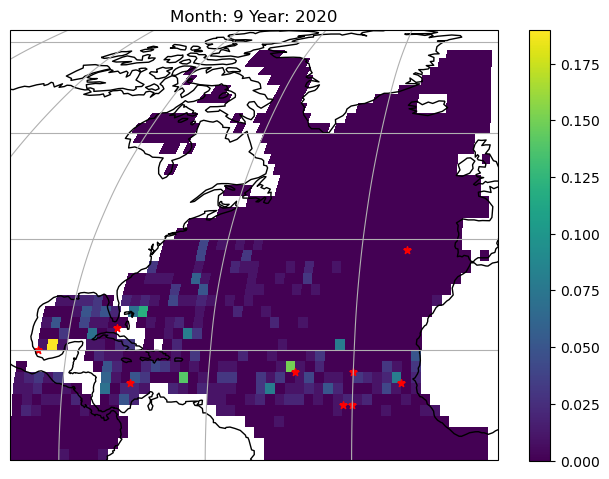

In [103]:
plotmonth = 9
plotyear = 2020
testlabelpoints = test_labels.__xarray_dataarray_variable__.unstack()
i1 = np.where(testlabelpoints.sel(Month=plotmonth,Year=plotyear) > 0)[0]
i2 = np.where(testlabelpoints.sel(Month=plotmonth,Year=plotyear) > 0)[1]

locations = testlabelpoints.sel(Month=plotmonth,Year=2005)[i1,i2]

probs = clf.predict_proba(test_env_data)
genesisprobs = 1 - probs[:,0]
testprobs_formatted = xr.DataArray(genesisprobs,coords=test_labels.coords).unstack()
plt.figure
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines()
genesisplot = ax.pcolormesh(testprobs_formatted.Longitude,testprobs_formatted.Latitude,testprobs_formatted.sel(Month=plotmonth,Year=plotyear),transform=ccrs.PlateCarree())
ax.scatter(locations.Longitude,locations.Latitude,transform=ccrs.PlateCarree(),s=30,marker='*',c='r')
ax.set_extent([-100, 0, 0, 80])
plt.colorbar(genesisplot)
plt.title('Month: ' + str(plotmonth) + ' Year: ' + str(plotyear))
plt.savefig('Genesis Plot',dpi=600)
plt.tight_layout()

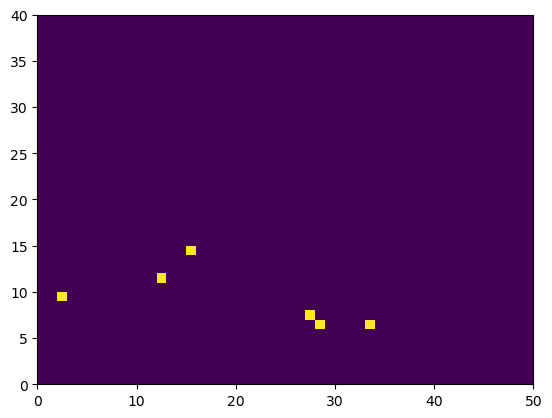

In [9]:
plt.pcolormesh(test_labels_predropped.unstack().sel(Month=8,Year=2005))


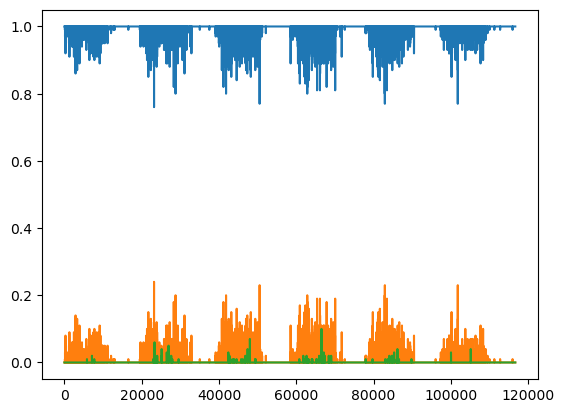

In [10]:
plt.plot(pd.DataFrame(clf.predict_proba(test_env_data)))

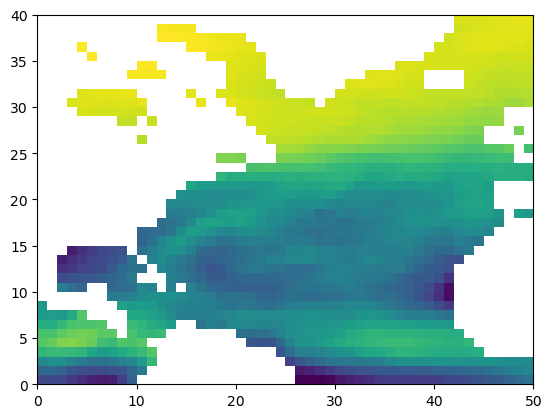

In [11]:
plt.pcolormesh(train_env_data.unstack()[3,4,:,:,0])